<a href="https://colab.research.google.com/github/davkeem/SHAZAM-CAPSTONE/blob/main/shazam_query_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os


drive.mount('/content/drive')

mfcc_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/mfcc'
hist_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/hist_data'
chroma_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/processed_chroma/ml_processed_data'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This loads the csv files, skips the first row and column of labels, and pads the histogram array to match up with the mfcc array.

Expected data shapes:
X shape: (20, 550, 14)
y shape: (20, 550, 1)

In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_data(directory):
    data = []
    for file_name in sorted(os.listdir(directory)):
        if file_name.endswith('.csv'):
            file_path = os.path.join(directory, file_name)
            df = pd.read_csv(file_path, header=None, skiprows=1)
            data.append(df.iloc[:, 1:].values)  # Exclude the time bin column
    max_length = max(array.shape[0] for array in data)  # Determine max length
    padded_data = pad_sequences(data, maxlen=max_length, padding='post', dtype='float32')  # Pad sequences
    return np.array(padded_data)

# Load MFCC, chroma, and histogram data
X_mfcc = load_data(mfcc_data_folder)  # MFCC data
X_chroma = load_data(chroma_data_folder)  # Chroma data
y = load_data(hist_data_folder)  # Histogram data

# Check if MFCC and chroma data have the same shape and concatenate
if X_mfcc.shape[1] != X_chroma.shape[1]:
    raise ValueError("MFCC and chroma data must have the same number of time steps.")

X = np.concatenate((X_mfcc, X_chroma), axis=-1)  # Concatenate along the last axis

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")




X shape: (20, 550, 27)
y shape: (20, 550, 1)


Work In Progress

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training on Song 1
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 4782518.5000
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 4082978.5000
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 3463843.2500
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 2924895.0000
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 2259329.7500
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 1861362.7500
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - loss: 1436949.7500
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 1174507.0000
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 933076.6250
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 777863.5000
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 647836.8750
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 582447.0625
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 482358.3750
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 459

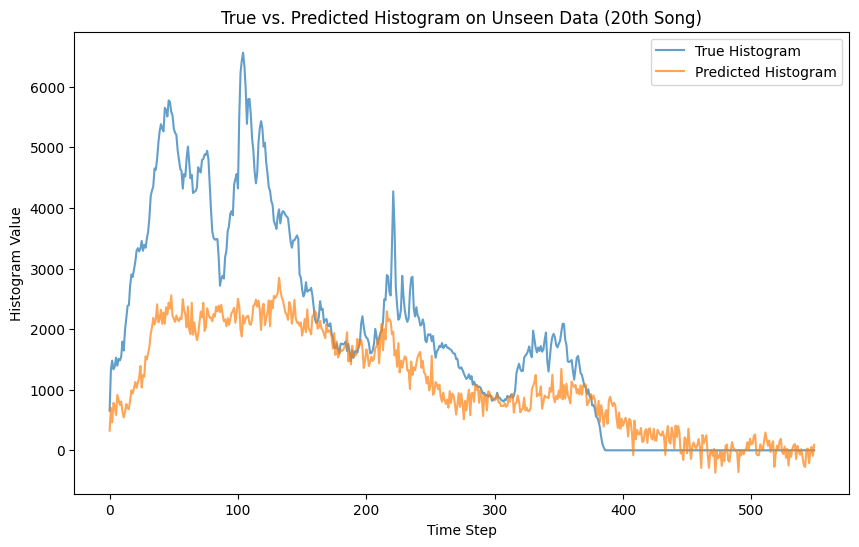

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


loo = LeaveOneOut()

# Split the data
X_train = X[:19]  # First 19 songs for training
y_train = y[:19]
X_test = X[19:]   # 20th song for testing
y_test = y[19:]

# Build the model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(550, 27)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(550, activation='linear'))  # 550 time steps
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Train the model
early_stopping = EarlyStopping(monitor='loss', patience=3)
model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=1, callbacks=[early_stopping])

# Evaluate the model on the unseen test song
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE on Unseen Data: {loss}")

# Make predictions
y_pred = model.predict(X_test).flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred))
print(f"Test RMSE on Unseen Data: {rmse}")

# Plot the true vs. predicted histograms
plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten(), label='True Histogram', alpha=0.7)
plt.plot(y_pred, label='Predicted Histogram', alpha=0.7)
plt.xlabel('Time Step')
plt.ylabel('Histogram Value')
plt.title('True vs. Predicted Histogram on Unseen Data')
plt.legend()
plt.show()


My first attempt at LOO (Leave One Out) Cross Validation modeling.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 6143292.0000
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 5194458.0000
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 4455589.0000
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 3787950.0000
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 3202232.7500
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 2677138.7500
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 2269398.7500
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 1946670.3750
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 1664475.6250
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 1469743.1250
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 1315122.1250
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 1217337.0000
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 1137679.7500
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 1102650.6250
Epoc

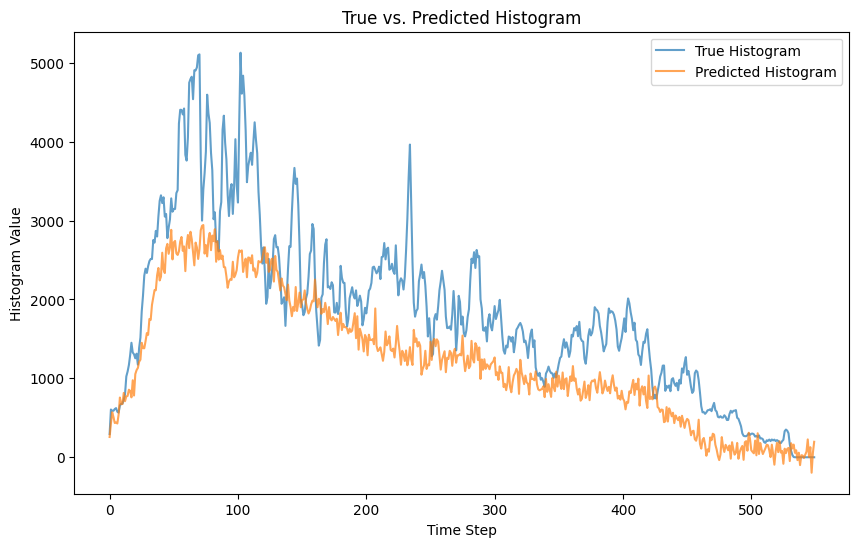

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 677836.5000
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 661211.5000
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 649793.7500
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 651048.9375
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 643414.3750
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 639530.6250
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 633463.8750
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 628121.8750
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 616192.8125
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 604603.1250
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 609102.3750
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 604929.4375
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 595707.8125
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 594974.7500
Epoch 15/40
1/1

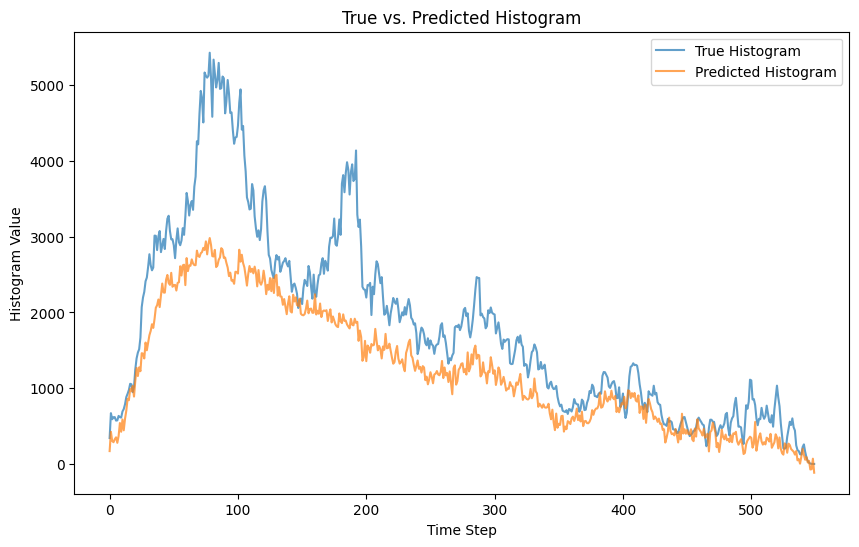

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 427275.3750
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 419489.4375
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 426638.2500
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 422121.7812
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 417485.5625
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 409690.8125
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 404121.5938
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 396678.0625
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 397319.3750
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 399252.5312
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 391128.9062
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 384293.7500
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 381002.5312
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 377499.5938
Epoch 15/40
1/1

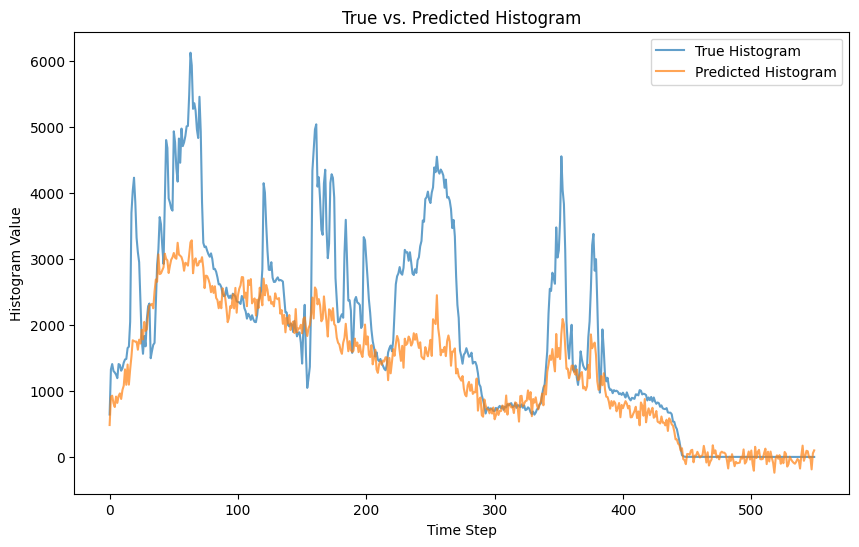

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 366959.5938
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 365177.7812
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 363526.9688
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - loss: 341949.0312
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - loss: 347058.0938
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step - loss: 350788.4062
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step - loss: 345357.5625
Test MSE for this fold: 1412898.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Test RMSE for this fold: 1188.65380859375


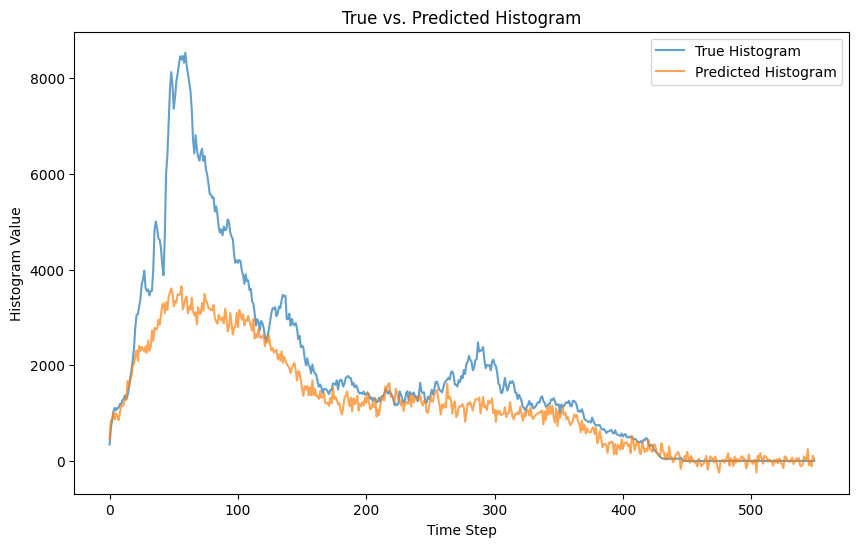

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - loss: 354477.7500
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 357686.5000
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - loss: 364008.5938
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step - loss: 347364.1250
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - loss: 346174.9375
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 353779.0000
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 341161.7812
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 347282.5938
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 342101.6875
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 332331.2500
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 326195.4688
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 330225.7500
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 322165.7500
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 322218.0312
Epoch 15/40
1/1

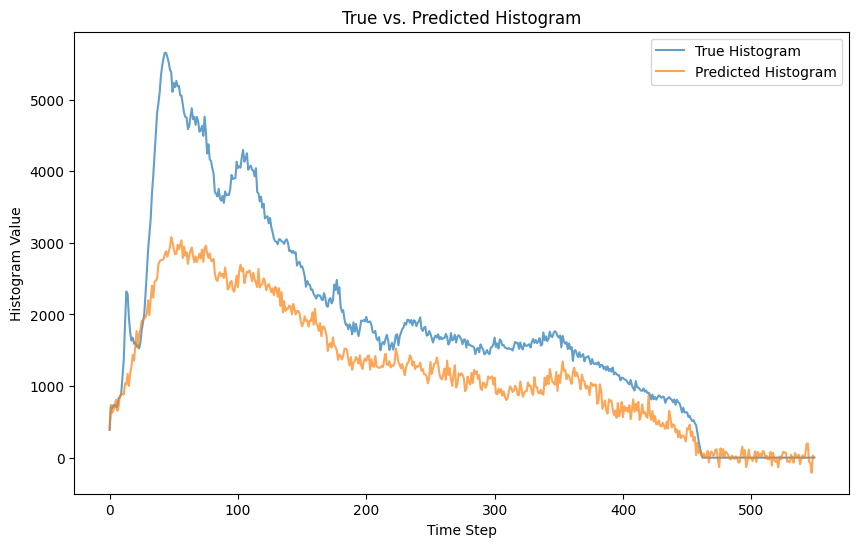

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 309559.7500
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step - loss: 308832.4688
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 301835.7812
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 302209.0625
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 299260.2500
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 299818.7500
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 298514.9375
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 288138.3125
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 295449.0938
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 282162.0625
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 278465.9062
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 281978.4062
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 273738.8438
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 275070.0938
Epoch 15/40
1/1

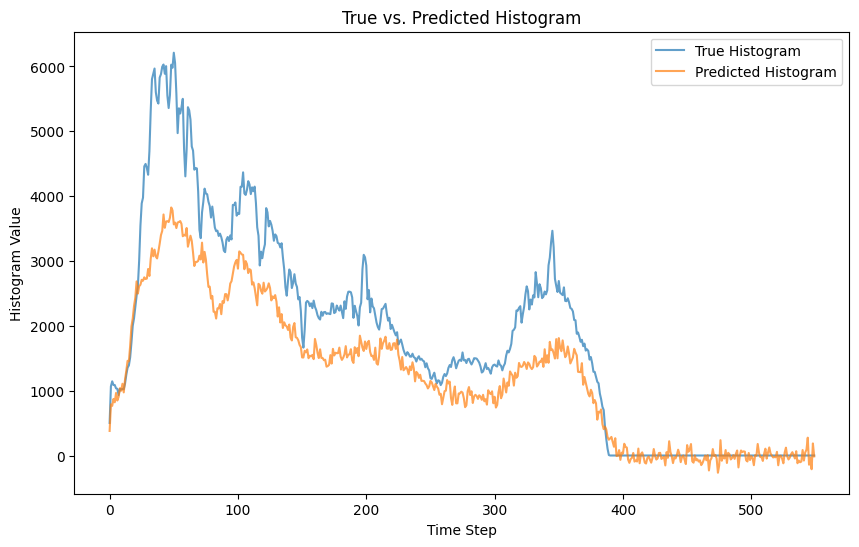

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - loss: 263911.0625
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 255908.4219
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 256294.2031
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 247730.4219
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 247844.1562
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 254970.7656
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 244064.3438
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 250848.6250
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 242947.3750
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 242053.7344
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 245056.2031
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 238400.6875
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 232959.3750
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 239008.0000
Epoch 15/40
1/1

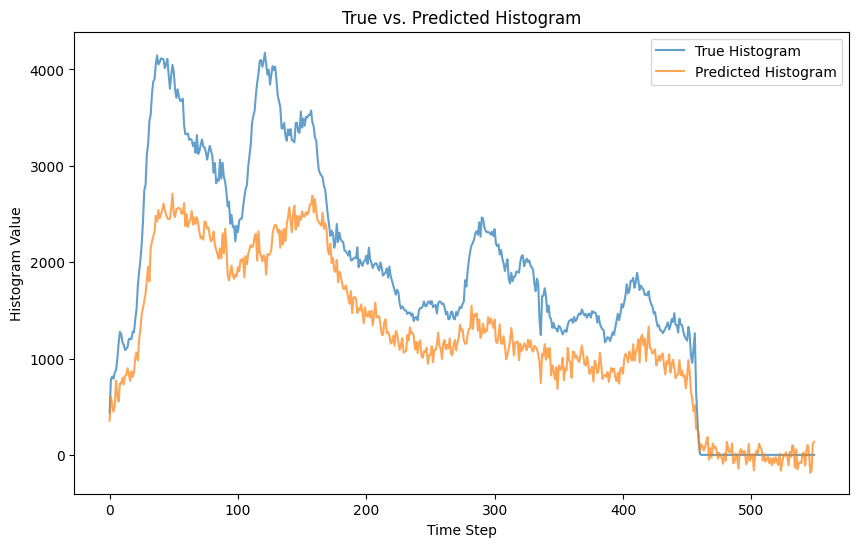

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 232026.3125
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 221471.6250
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 213213.2031
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 217393.1875
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 210560.2188
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 219359.2031
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 211666.9062
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 219881.6250
Test MSE for this fold: 905119.5625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Test RMSE for this fold: 951.3777465820312


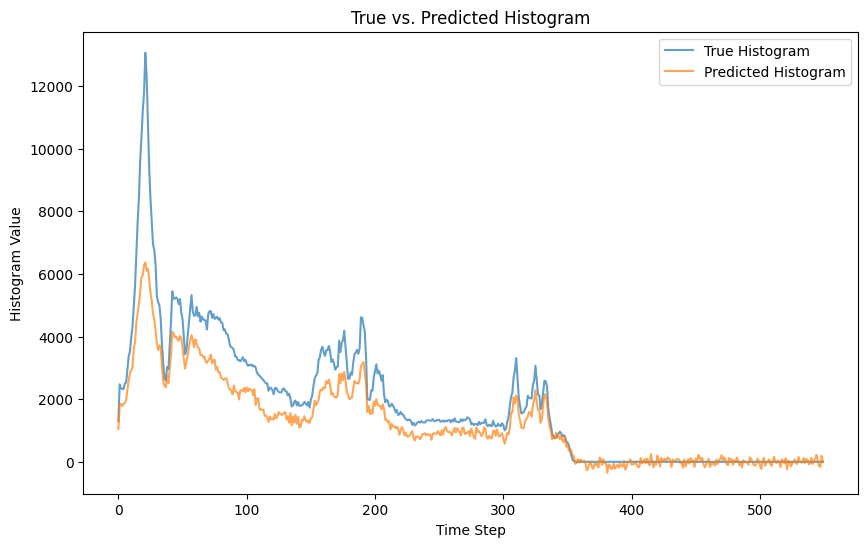

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 225248.7656
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 213839.9375
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 218157.5469
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 214892.3750
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 219351.9531
Test MSE for this fold: 575198.9375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Test RMSE for this fold: 758.418701171875


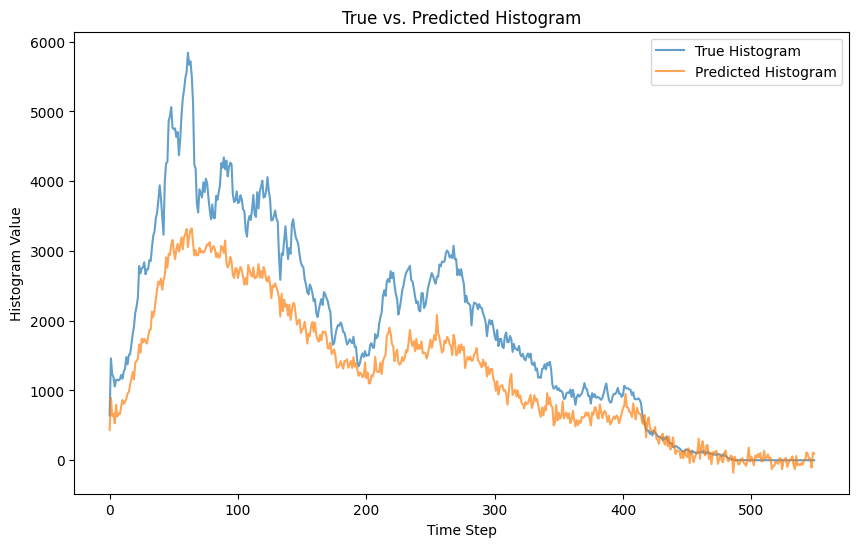

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 198562.3750
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 199306.3438
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 203360.2188
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - loss: 193666.4531
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 193516.0938
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - loss: 197699.2188
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step - loss: 188390.8125
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step - loss: 194788.7500
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step - loss: 194170.4062
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step - loss: 191592.9531
Test MSE for this fold: 1233565.125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Test RMSE for this fold: 1110.6597900390625


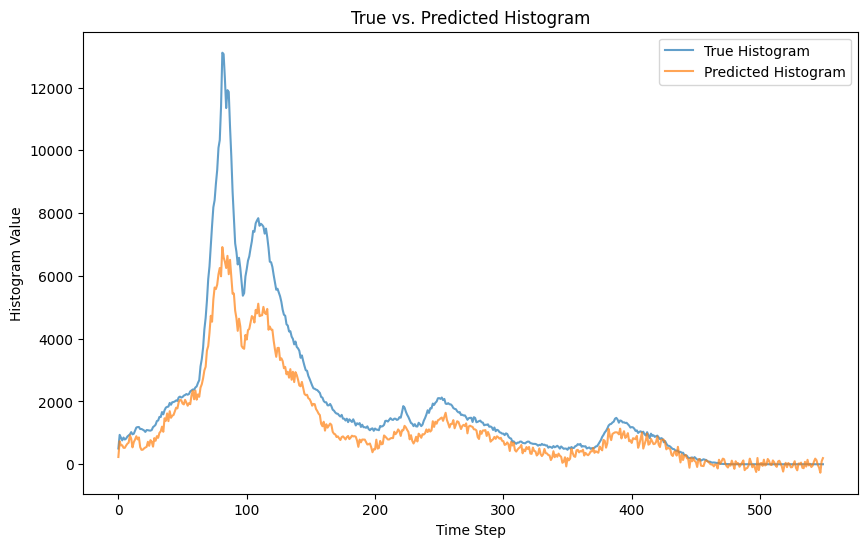

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 202092.1406
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 206030.4688
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 198886.2969
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 193420.2656
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 199270.1875
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 195456.6250
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 195068.2344
Test MSE for this fold: 694415.875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Test RMSE for this fold: 833.3162231445312


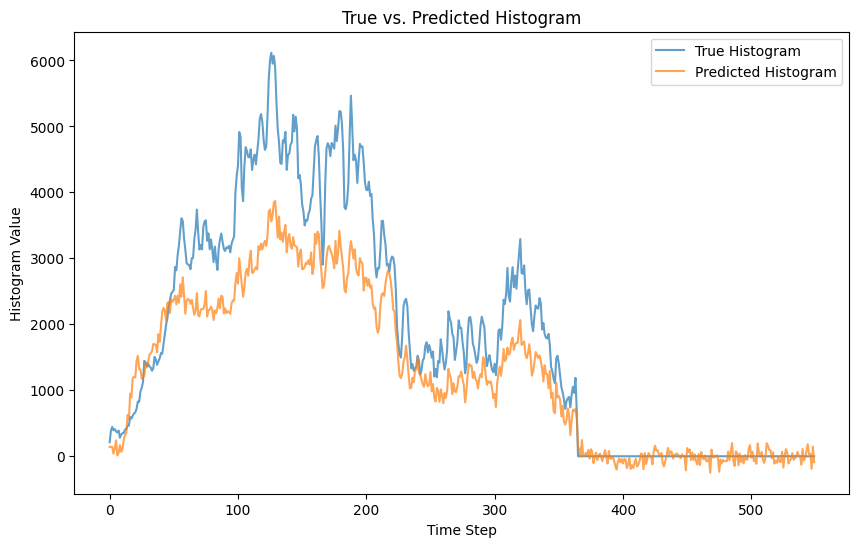

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 192828.3594
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 196235.6250
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 194931.3750
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 192108.5781
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 193043.5000
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 186052.2031
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 189885.7812
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 183334.7969
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 179899.0156
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 187879.8594
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 179508.9219
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 183112.2500
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 179658.6562
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 179123.7031
Epoch 15/40
1/1

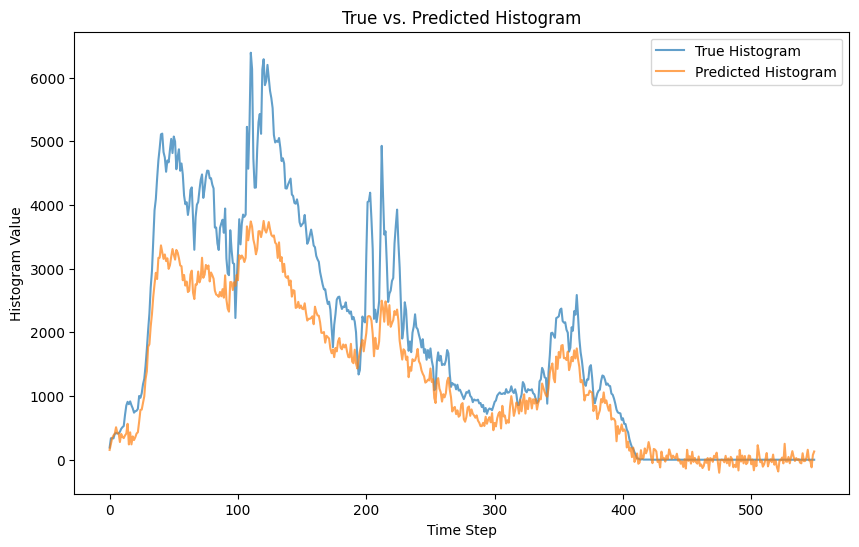

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 178025.9688
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 172606.0781
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step - loss: 167646.7969
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step - loss: 174150.0469
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step - loss: 173456.6094
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 166126.6250
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - loss: 172593.5469
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - loss: 163139.5312
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step - loss: 169272.4688
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - loss: 165843.3438
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 169234.2812
Test MSE for this fold: 534300.625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Test RMSE for this fold: 730.9586791992188


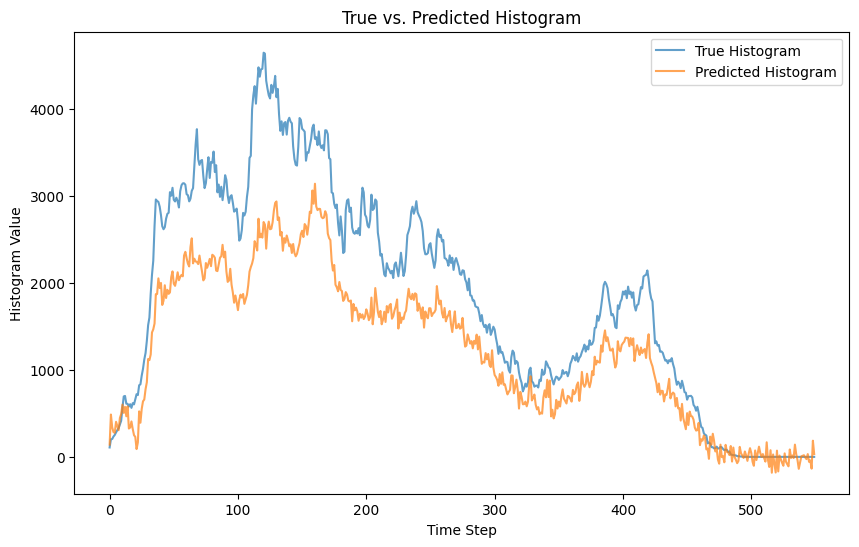

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 167121.0469
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 165802.6875
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 166430.5000
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 164636.6562
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 159685.9688
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 157824.8281
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 159545.9531
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 155793.4688
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 155014.9531
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 155581.4062
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 154201.5469
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 152445.7031
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 151601.5469
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 152999.3594
Epoch 15/40
1/1

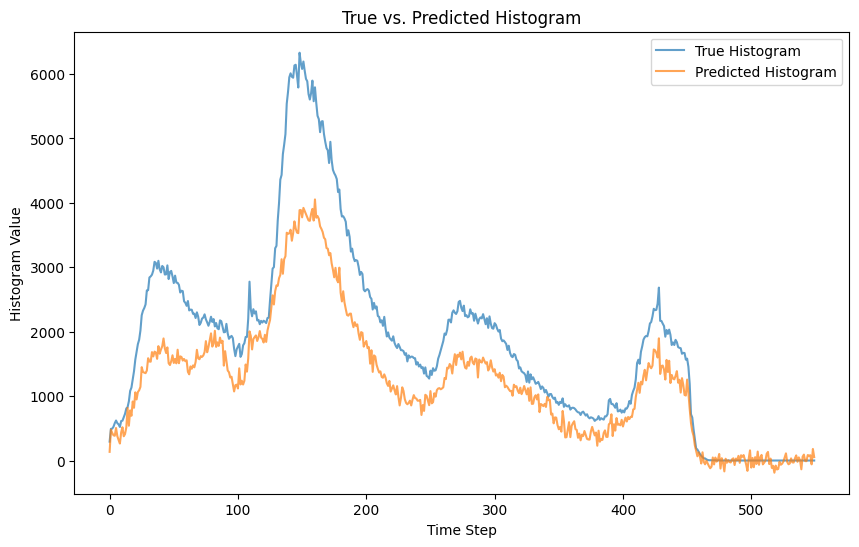

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 142672.1250
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - loss: 139177.4688
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - loss: 135806.5938
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step - loss: 140609.4219
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - loss: 144315.3750
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step - loss: 141356.0781
Test MSE for this fold: 682445.625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Test RMSE for this fold: 826.1026611328125


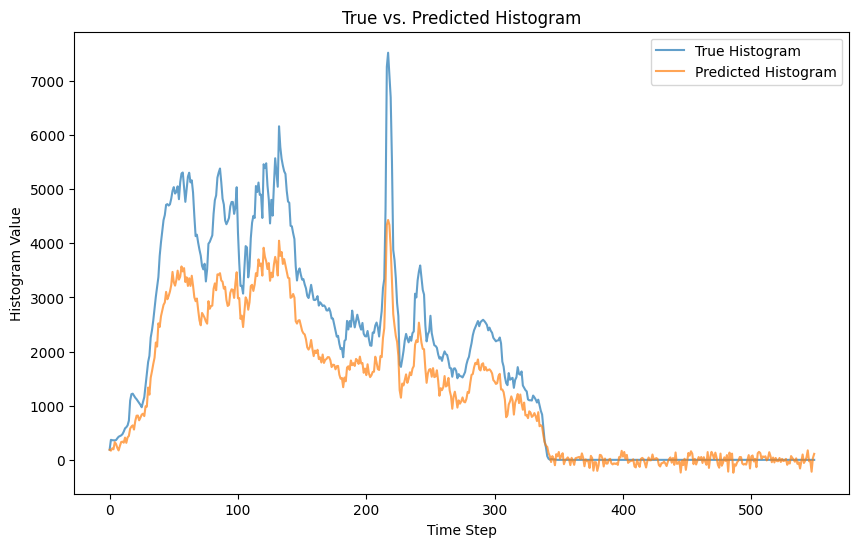

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - loss: 140976.5938
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 135444.0938
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 141147.3750
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 138843.2344
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 132987.5156
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 137358.4219
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 136434.8438
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 129357.5000
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 129197.6016
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 128990.3047
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 132295.3750
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 134196.5625
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 131853.7969
Test MSE for this fold: 628643.3125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test RMSE fo

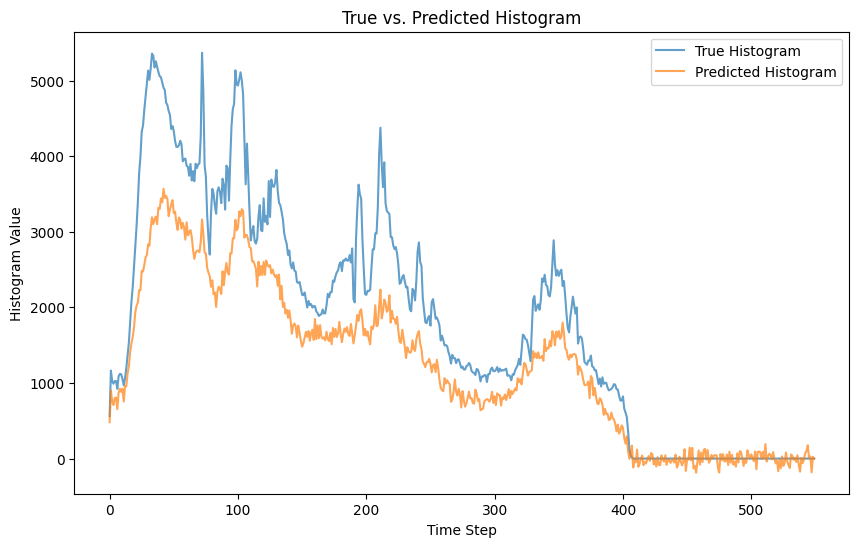

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 132592.2656
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 136698.1562
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 131510.5938
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 137580.8750
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 132689.8125
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 129753.1875
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 127316.5938
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - loss: 132033.6875
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 125437.0781
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 127189.1172
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 127851.4844
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 128874.7500
Test MSE for this fold: 649328.875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test RMSE for this fold: 805.8094482421875


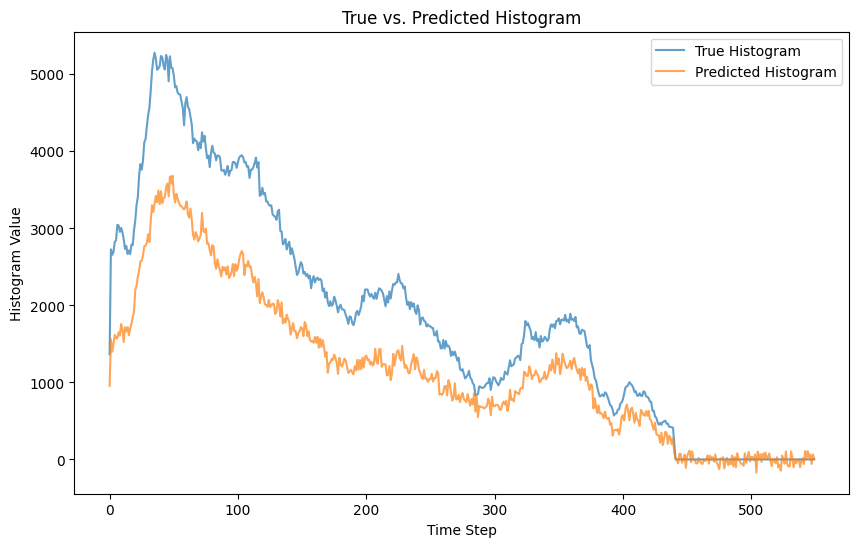

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 122780.9375
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 130676.6484
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 127353.3828
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 125478.6562
Test MSE for this fold: 629242.1875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test RMSE for this fold: 793.2478637695312


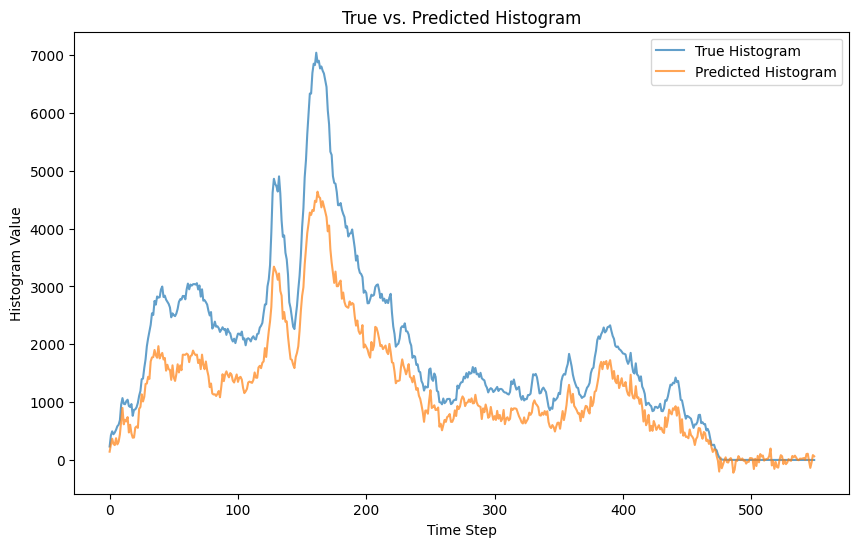

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 124249.0234
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 119257.0938
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 126217.9062
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 118185.1016
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 125012.7891
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step - loss: 123109.2656
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step - loss: 122800.5547
Test MSE for this fold: 694298.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Test RMSE for this fold: 833.2457275390625


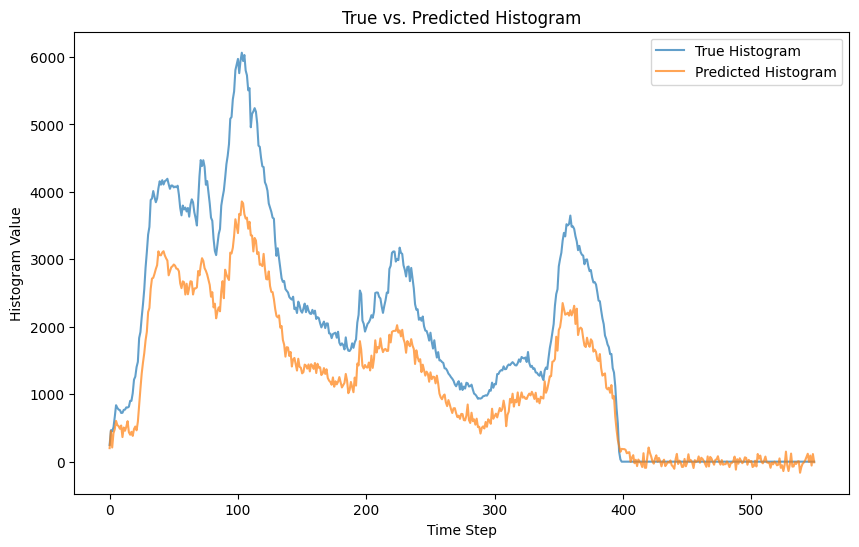

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - loss: 120497.5938
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - loss: 118904.3828
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step - loss: 119421.9766
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - loss: 111687.3281
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - loss: 116964.6875
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step - loss: 115325.5391
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - loss: 113586.5156
Test MSE for this fold: 815295.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Test RMSE for this fold: 902.9371337890625


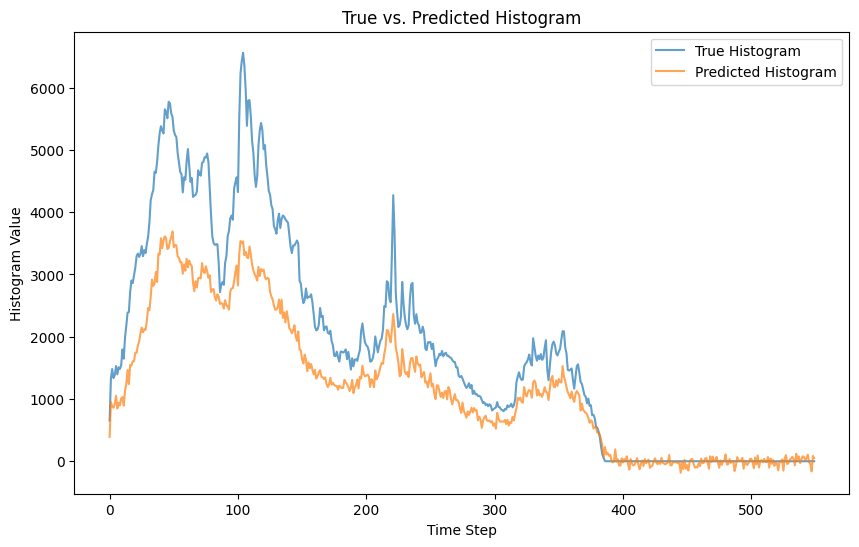

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Initialize Leave-One-Out cross-validator
loo = LeaveOneOut()

model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(550, 27)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(550, activation='linear'))  # 550 max time steps
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Loop through each song for LOO CV and continue training
for train_index, test_index in loo.split(X):
    # Split the data into training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    early_stopping = EarlyStopping(monitor='loss', patience=3)
    model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=1, callbacks=[early_stopping])

    # Evaluate the model on the test set
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test MSE for this fold: {loss}")

    # Make predictions
    y_pred = model.predict(X_test).flatten()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred))
    print(f"Test RMSE for this fold: {rmse}")

    # Plot the true vs. predicted histograms
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.flatten(), label='True Histogram', alpha=0.7)
    plt.plot(y_pred, label='Predicted Histogram', alpha=0.7)
    plt.xlabel('Time Step')
    plt.ylabel('Histogram Value')
    plt.title('True vs. Predicted Histogram')
    plt.legend()
    plt.show()

# Final Validation: Evaluate the model on all songs
#print("\n--- Final Validation ---")
#for i in range(len(X)):
    #y_pred_final = model.predict(np.expand_dims(X[i], axis=0)).flatten() #Need to add 1 to make it 3 parameters  again
    #rmse_final = np.sqrt(mean_squared_error(y[i].flatten(), y_pred_final))

    #print(f"Song {i+1} - Final Validation RMSE: {rmse_final}")

    # Plot the final true vs. predicted histograms
    #plt.figure(figsize=(10, 6))
    #plt.plot(y[i].flatten(), label='True Histogram', alpha=0.7)
    #plt.plot(y_pred_final, label='Predicted Histogram', alpha=0.7)
    #plt.xlabel('Time Step')
    #plt.ylabel('Histogram Value')
    #plt.title(f'Song {i+1} - Final True vs. Predicted Histogram')
    #plt.legend()
    #plt.show()
